In [73]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from typing import Dict, Tuple, List, Union, Any
from pathlib import Path
from jsonlines import jsonlines
from loguru import logger
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from src.settings import EMBEDDINGS_DIR

tqdm.pandas()

In [2]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')
print(f"{DEVICE=}")

torch.cuda.empty_cache()

DEVICE=device(type='cuda', index=0)


## Dataset

In [3]:
augmented_pl_df = pd.read_feather(EMBEDDINGS_DIR / 'augmented_pl_annots_wth_emb_df.feather')  #.sample(frac=0.5)

# drop parahrases that are the same as the original text
augmented_pl_df = augmented_pl_df.drop_duplicates(subset=['text'], keep="first")
augmented_pl_df

,start,end,text,doc_filepath,video_filename,task_label,ParaphraseSrcIndex,EmbeddingModel,Embedding
0,39040,41120,"Myślę, że mam inny pomysł, można?",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.039401535, 0.045144096, -0.07359799, 0.999..."
1,41120,49680,"Chyba ten znak mówi, że jak ktoś będzie spacer...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.04103174, 0.18905145, -0.2473697, 0.999101..."
2,49680,55280,Trzeba przejść łukiem obok leżącego i o tym zn...,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.099419735, 0.2554967, -0.2758171, 0.996696..."
3,61280,66840,"Okrągły znak pomaga nam, mówi, że są pasy na u...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.23825723, -0.018337265, -0.06085317, 0.998..."
4,66840,73200,"Jak ktoś zobaczy, ale zignoruje ten znak, to m...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.12970479, 0.22667503, -0.34039426, 0.99525..."
...,...,...,...,...,...,...,...,...,...
47539,833160,834400,Zawsze zimą w góry.,/07/K59AF01-11_07_07_calendar.eaf,K59AF01-11.mp4,07,22202.0,allegro/herbert-base-cased,"[-0.05857093, 0.14995597, -0.26642218, 0.99614..."
47540,237680,240440,"Kiedy idzie, zauważa, że okno jest rozbite.",/17/K03BF01-21_17_kid_17_kid_chaplin.eaf,K03BF01-21.mp4,17,26633.0,allegro/herbert-base-cased,"[-0.2766317, -0.043460898, -0.09275186, 0.9882..."
47542,107000,110120,"Popisuje się, odbijając piłkę rakietką.",/17/K08AF17-26_17_pears_17_pears_pears.eaf,K08AF17-26.mp4,17,23505.0,allegro/herbert-base-cased,"[-0.074502006, -0.020844987, 0.052832212, 0.99..."
47545,23480,26760,"On właśnie mówi im, że jest zmęczony i chce iś...",/24/K67AF13-26_24_24_alarm.eaf,K67AF13-26.mp4,24,11942.0,allegro/herbert-base-cased,"[0.015946332, -0.046507165, -0.20022015, 0.998..."


In [4]:
augmented_pl_df.ParaphraseSrcIndex.notna().sum()

4891

In [5]:
id2label = {i: label for i, label in enumerate(sorted(augmented_pl_df["task_label"].unique(), key=lambda x: int(x)))}
label2id = {label: i for i, label in id2label.items()}

id2label

{0: '07', 1: '08', 2: '13', 3: '15', 4: '17', 5: '24'}

In [6]:
def get_target_vec(label, label2id):
    target_vec = np.zeros(len(label2id))
    target_vec[label2id[label]] = 1
    return target_vec

augmented_pl_df["Target"] = augmented_pl_df["task_label"].apply(get_target_vec, args=(label2id,))

In [7]:
augmented_pl_df

,start,end,text,doc_filepath,video_filename,task_label,ParaphraseSrcIndex,EmbeddingModel,Embedding,Target
0,39040,41120,"Myślę, że mam inny pomysł, można?",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.039401535, 0.045144096, -0.07359799, 0.999...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
1,41120,49680,"Chyba ten znak mówi, że jak ktoś będzie spacer...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.04103174, 0.18905145, -0.2473697, 0.999101...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
2,49680,55280,Trzeba przejść łukiem obok leżącego i o tym zn...,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.099419735, 0.2554967, -0.2758171, 0.996696...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
3,61280,66840,"Okrągły znak pomaga nam, mówi, że są pasy na u...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.23825723, -0.018337265, -0.06085317, 0.998...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
4,66840,73200,"Jak ktoś zobaczy, ale zignoruje ten znak, to m...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.12970479, 0.22667503, -0.34039426, 0.99525...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...
47539,833160,834400,Zawsze zimą w góry.,/07/K59AF01-11_07_07_calendar.eaf,K59AF01-11.mp4,07,22202.0,allegro/herbert-base-cased,"[-0.05857093, 0.14995597, -0.26642218, 0.99614...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
47540,237680,240440,"Kiedy idzie, zauważa, że okno jest rozbite.",/17/K03BF01-21_17_kid_17_kid_chaplin.eaf,K03BF01-21.mp4,17,26633.0,allegro/herbert-base-cased,"[-0.2766317, -0.043460898, -0.09275186, 0.9882...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
47542,107000,110120,"Popisuje się, odbijając piłkę rakietką.",/17/K08AF17-26_17_pears_17_pears_pears.eaf,K08AF17-26.mp4,17,23505.0,allegro/herbert-base-cased,"[-0.074502006, -0.020844987, 0.052832212, 0.99...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
47545,23480,26760,"On właśnie mówi im, że jest zmęczony i chce iś...",/24/K67AF13-26_24_24_alarm.eaf,K67AF13-26.mp4,24,11942.0,allegro/herbert-base-cased,"[0.015946332, -0.046507165, -0.20022015, 0.998...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]"


In [8]:
pl_df = augmented_pl_df[augmented_pl_df.ParaphraseSrcIndex.isna()].copy()
pl_df

,start,end,text,doc_filepath,video_filename,task_label,ParaphraseSrcIndex,EmbeddingModel,Embedding,Target
0,39040,41120,"Myślę, że mam inny pomysł, można?",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.039401535, 0.045144096, -0.07359799, 0.999...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
1,41120,49680,"Chyba ten znak mówi, że jak ktoś będzie spacer...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.04103174, 0.18905145, -0.2473697, 0.999101...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
2,49680,55280,Trzeba przejść łukiem obok leżącego i o tym zn...,/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.099419735, 0.2554967, -0.2758171, 0.996696...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
3,61280,66840,"Okrągły znak pomaga nam, mówi, że są pasy na u...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.23825723, -0.018337265, -0.06085317, 0.998...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
4,66840,73200,"Jak ktoś zobaczy, ale zignoruje ten znak, to m...",/15/K66BF13-26_15_15_signsNO.eaf,K66BF13-26.mp4,15,NaN,allegro/herbert-base-cased,"[-0.12970479, 0.22667503, -0.34039426, 0.99525...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...
39618,248960,250320,[uderzanie w coś],/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,13,NaN,allegro/herbert-base-cased,"[-0.18567182, 0.09094109, -0.0705645, 0.998525...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
39619,279560,291400,Kot zobaczył w akwarium rybkę. Podszedł i dał ...,/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,13,NaN,allegro/herbert-base-cased,"[-0.006999457, -0.033343293, -0.19992304, 0.99...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
39620,291400,347120,"Zjadłam, zjadłam.",/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,13,NaN,allegro/herbert-base-cased,"[-0.0022181608, 0.15197508, -0.0095874565, 0.9...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"
39621,347120,356440,"Zając biegnie, zobaczył wiszące pranie. Wskocz...",/13/K17BF13-26_13_13_comics.eaf,K17BF13-26.mp4,13,NaN,allegro/herbert-base-cased,"[0.046771158, -0.19330795, -0.19553015, 0.9970...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]"


In [9]:
class OrkpjmTaskDataset(Dataset):

    def __init__(self, augmented_df, augment=False):
        self.df = augmented_df.copy()
        if not augment:
            self.df = self.df[self.df.ParaphraseSrcIndex.isna()]

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        return {
            "embedding": torch.tensor(self.df.Embedding.iloc[index]),
            "target": torch.tensor(self.df.Target.iloc[index]),
        }

In [10]:
aug_train_df, aug_val_df = train_test_split(augmented_pl_df, test_size=0.2, random_state=42, stratify=augmented_pl_df["task_label"])

len(aug_train_df), len(aug_val_df)

(29491, 7373)

In [11]:
train_ds = OrkpjmTaskDataset(aug_train_df)
val_ds = OrkpjmTaskDataset(aug_val_df)

In [12]:
aug_train_ds = OrkpjmTaskDataset(aug_train_df, augment=True)
aug_val_ds = OrkpjmTaskDataset(aug_val_df, augment=True)

## Data loaders

In [13]:
EMBEDDINGS_DIM = 768
BATCH_SIZE = 64
NUM_LABELS = 6


train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

aug_train_dl = DataLoader(aug_train_ds, batch_size=BATCH_SIZE)
aug_val_dl = DataLoader(aug_train_ds, batch_size=BATCH_SIZE)

## Simple NN

In [14]:
class SimpleNNclf(nn.Module):

    def __init__(self, embedding_dim, num_classes, hidden_dim=256, dropout=0.5):
        super().__init__()
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = nn.functional.relu(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return nn.functional.softmax(x, dim=1)

In [120]:
SimpleNNclf(EMBEDDINGS_DIM, NUM_LABELS)

SimpleNNclf(
  (fc1): Linear(in_features=768, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)

## LSTM

In [15]:
class LSTMclf(nn.Module):

    def __init__(self, input_dim, num_classes, hidden_dim=256):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, bidirectional=False, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1])
        # x shape: [batch_size, sequence_length, embedding_dim]
        lstm_out, _ = self.lstm(x)
        # Take the output of the last time step
        lstm_out = lstm_out[:, -1, :]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        return nn.functional.softmax(out, dim=1)

In [121]:
LSTMclf(EMBEDDINGS_DIM, NUM_LABELS)

LSTMclf(
  (lstm): LSTM(768, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)

In [16]:
def train(model, optimizer, loss_fn, train_dl, device="cuda", norm_grad=False):
    # one epoch training
    model.train()
    total_loss = 0

    all_targets_label_ids, all_preds_label_ids = [], []
    for batch in train_dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        inputs, targets = batch["embedding"], batch["target"]

        optimizer.zero_grad()
        preds = model(inputs)
        loss = loss_fn(preds, targets)
        total_loss = total_loss + loss.item()
        loss.backward()

        if norm_grad:
            # Normalizacja wartości gradientów
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        preds_label_ids = torch.argmax(preds, dim=1)
        targets_label_ids = torch.argmax(targets, dim=1)

        all_preds_label_ids.extend(preds_label_ids.detach().cpu().numpy())
        all_targets_label_ids.extend(targets_label_ids.detach().cpu().numpy())

    avg_loss = total_loss / len(train_dl)

    print(all_targets_label_ids[:10], all_preds_label_ids[:10])
    
    clf_report = classification_report(all_targets_label_ids, all_preds_label_ids, output_dict=True, zero_division=0)

    return avg_loss, clf_report


def evaluate(model, loss_fn, val_dl, device="cuda"):
    # one epoch evaluation
    model.eval()
    total_loss = 0
    all_targets_label_ids, all_preds_label_ids = [], []
    for batch in val_dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        inputs, targets = batch["embedding"], batch["target"]

        with torch.no_grad():
            preds = model(inputs)
            loss = loss_fn(preds, targets)
            total_loss = total_loss + loss.item()

        targets_label_ids = torch.argmax(targets, dim=1)
        preds_label_ids = torch.argmax(preds, dim=1)

        all_preds_label_ids.extend(preds_label_ids.detach().cpu().numpy())
        all_targets_label_ids.extend(targets_label_ids.detach().cpu().numpy())

    avg_loss = total_loss / len(val_dl)
    clf_report = classification_report(all_targets_label_ids, all_preds_label_ids, output_dict=True, zero_division=0)

    return avg_loss, clf_report

In [17]:
EPOCHS = 30
LEARNING_RATE = 1e-3


training_history = []
for (exp_train_dl, exp_val_dl), augmented in [
    ((train_dl, val_dl), False),
    ((aug_train_dl, aug_val_dl), True),
]:

    for model_base_class in [
        LSTMclf,
        SimpleNNclf
    ]:
        torch.cuda.empty_cache()

        model = model_base_class(EMBEDDINGS_DIM, NUM_LABELS).to(DEVICE)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        model_name = model.__class__.__name__
        for epoch in tqdm(range(EPOCHS), desc=f"Training {model_name}\t| Epochs"):
            train_loss, train_clf_report = train(model, optimizer, loss_fn, train_dl, norm_grad=False, device=DEVICE)
            val_loss, val_clf_report = evaluate(model, loss_fn, val_dl, device=DEVICE)

            train_f1 = train_clf_report["macro avg"]["f1-score"]
            val_f1 = val_clf_report["macro avg"]["f1-score"]

            logger.info(f"Augmented: {augmented}\tTrain loss: {train_loss:.4f} Val loss: {val_loss:.4f} Train F1: {train_f1:.4f} Val F1: {val_f1:.4f}")

            training_history.append({
                "Epoch": epoch,
                "Model": model_name,
                "AugmentedDataset": augmented,
                "TrainLoss": train_loss,
                "ValLoss": val_loss,
                "TrainF1": train_f1,
                "ValF1": val_f1,
                "_ValClfReport": val_clf_report,
            })


Training LSTMclf	| Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [0, 0, 2, 0, 0, 4, 4, 0, 0, 2]


2024-01-30 00:28:18.990 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.5526 Val loss: 1.4839 Train F1: 0.3226 Val F1: 0.3840


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 4, 0, 3, 3, 4, 0, 0, 3, 3]


2024-01-30 00:28:21.344 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4643 Val loss: 1.4525 Train F1: 0.4061 Val F1: 0.4278


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 3, 3]


2024-01-30 00:28:23.974 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4456 Val loss: 1.4571 Train F1: 0.4388 Val F1: 0.4407


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 0, 3]


2024-01-30 00:28:26.704 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4366 Val loss: 1.4357 Train F1: 0.4562 Val F1: 0.4550


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 0, 3]


2024-01-30 00:28:29.441 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4215 Val loss: 1.4251 Train F1: 0.4793 Val F1: 0.4751


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 0, 3]


2024-01-30 00:28:32.285 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4178 Val loss: 1.4099 Train F1: 0.4909 Val F1: 0.4886


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:28:35.194 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4137 Val loss: 1.4104 Train F1: 0.5001 Val F1: 0.4832


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:28:38.067 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4092 Val loss: 1.4213 Train F1: 0.5161 Val F1: 0.4964


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 4, 3]


2024-01-30 00:28:41.158 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4023 Val loss: 1.4051 Train F1: 0.5253 Val F1: 0.5058


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 4, 3]


2024-01-30 00:28:44.175 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3947 Val loss: 1.4052 Train F1: 0.5409 Val F1: 0.5233


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 5, 3]


2024-01-30 00:28:47.287 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3935 Val loss: 1.4094 Train F1: 0.5425 Val F1: 0.5121


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 4, 3]


2024-01-30 00:28:50.383 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3945 Val loss: 1.3955 Train F1: 0.5446 Val F1: 0.5421


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 5, 3]


2024-01-30 00:28:53.436 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3912 Val loss: 1.3937 Train F1: 0.5511 Val F1: 0.5281


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:28:56.476 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3856 Val loss: 1.3972 Train F1: 0.5573 Val F1: 0.5416


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 3, 3]


2024-01-30 00:28:59.556 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3825 Val loss: 1.3958 Train F1: 0.5657 Val F1: 0.5653


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 0, 3]


2024-01-30 00:29:02.539 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3768 Val loss: 1.3977 Train F1: 0.5758 Val F1: 0.5526


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:29:05.380 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3775 Val loss: 1.3948 Train F1: 0.5810 Val F1: 0.5387


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 4, 3]


2024-01-30 00:29:08.134 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3733 Val loss: 1.3938 Train F1: 0.5820 Val F1: 0.5593


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 3, 3]


2024-01-30 00:29:11.167 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3696 Val loss: 1.3831 Train F1: 0.5917 Val F1: 0.5852


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 0, 3]


2024-01-30 00:29:14.135 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3646 Val loss: 1.3791 Train F1: 0.6009 Val F1: 0.5929


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:29:16.928 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3724 Val loss: 1.3888 Train F1: 0.5869 Val F1: 0.5702


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 0, 3]


2024-01-30 00:29:19.664 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3658 Val loss: 1.3774 Train F1: 0.5983 Val F1: 0.5791


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:29:22.378 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3674 Val loss: 1.3844 Train F1: 0.5958 Val F1: 0.5875


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:29:25.096 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3545 Val loss: 1.3752 Train F1: 0.6139 Val F1: 0.5941


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:29:27.882 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3572 Val loss: 1.3726 Train F1: 0.6148 Val F1: 0.5941


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:29:30.639 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3540 Val loss: 1.3713 Train F1: 0.6190 Val F1: 0.5954


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:29:33.363 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3547 Val loss: 1.3713 Train F1: 0.6190 Val F1: 0.5940


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:29:36.097 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3531 Val loss: 1.3709 Train F1: 0.6209 Val F1: 0.6032


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:29:38.791 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3553 Val loss: 1.3848 Train F1: 0.6193 Val F1: 0.5841


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 1, 3]


2024-01-30 00:29:41.512 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3491 Val loss: 1.3938 Train F1: 0.6275 Val F1: 0.5751


Training SimpleNNclf	| Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [1, 0, 1, 2, 1, 2, 0, 2, 0, 2]


2024-01-30 00:29:43.701 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.5912 Val loss: 1.5023 Train F1: 0.2783 Val F1: 0.3759


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 0, 3, 3]


2024-01-30 00:29:46.310 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4906 Val loss: 1.4832 Train F1: 0.3829 Val F1: 0.3984


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [0, 1, 0, 3, 0, 4, 0, 0, 0, 3]


2024-01-30 00:29:48.920 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4685 Val loss: 1.4551 Train F1: 0.4097 Val F1: 0.4414


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 0, 3]


2024-01-30 00:29:51.624 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4520 Val loss: 1.4399 Train F1: 0.4402 Val F1: 0.4468


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 1, 0, 4, 0, 3]


2024-01-30 00:29:54.291 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4428 Val loss: 1.4393 Train F1: 0.4526 Val F1: 0.4524


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 4, 4, 0, 4, 0, 3]


2024-01-30 00:29:56.737 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4365 Val loss: 1.4302 Train F1: 0.4649 Val F1: 0.4569


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 0, 3]


2024-01-30 00:29:59.323 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4281 Val loss: 1.4285 Train F1: 0.4772 Val F1: 0.4737


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:30:01.939 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4266 Val loss: 1.4229 Train F1: 0.4781 Val F1: 0.4729


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 0, 0, 4, 0, 4, 4, 3]


2024-01-30 00:30:04.514 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4221 Val loss: 1.4219 Train F1: 0.4828 Val F1: 0.4725


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 1, 0, 4, 4, 3]


2024-01-30 00:30:07.225 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4165 Val loss: 1.4206 Train F1: 0.4927 Val F1: 0.4826


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 1, 3]


2024-01-30 00:30:09.888 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4177 Val loss: 1.4271 Train F1: 0.5007 Val F1: 0.4627


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 1, 3]


2024-01-30 00:30:12.454 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4135 Val loss: 1.4208 Train F1: 0.5105 Val F1: 0.4735


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 0, 3]


2024-01-30 00:30:14.997 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4132 Val loss: 1.4141 Train F1: 0.5170 Val F1: 0.5108


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 0, 3]


2024-01-30 00:30:17.597 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4111 Val loss: 1.4295 Train F1: 0.5227 Val F1: 0.5127


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 4, 0, 3, 0, 4, 0, 4, 0, 3]


2024-01-30 00:30:20.238 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4071 Val loss: 1.4295 Train F1: 0.5321 Val F1: 0.4948


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 4, 3]


2024-01-30 00:30:22.815 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4060 Val loss: 1.4123 Train F1: 0.5369 Val F1: 0.5295


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 1, 3]


2024-01-30 00:30:25.373 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4014 Val loss: 1.4076 Train F1: 0.5461 Val F1: 0.5336


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 4, 4, 0, 4, 0, 3]


2024-01-30 00:30:27.944 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4021 Val loss: 1.4122 Train F1: 0.5457 Val F1: 0.5533


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 0, 3]


2024-01-30 00:30:30.574 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3983 Val loss: 1.4112 Train F1: 0.5508 Val F1: 0.5250


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 4, 3]


2024-01-30 00:30:33.147 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.4003 Val loss: 1.4243 Train F1: 0.5472 Val F1: 0.5036


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 4, 0, 3, 3, 4, 0, 4, 1, 3]


2024-01-30 00:30:35.666 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3977 Val loss: 1.4042 Train F1: 0.5551 Val F1: 0.5563


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 4, 0, 3, 0, 4, 0, 4, 4, 3]


2024-01-30 00:30:38.210 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3959 Val loss: 1.4117 Train F1: 0.5553 Val F1: 0.5291


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 4, 4, 0, 4, 4, 3]


2024-01-30 00:30:40.655 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3919 Val loss: 1.4082 Train F1: 0.5619 Val F1: 0.5310


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 4, 0, 3, 0, 4, 0, 4, 0, 3]


2024-01-30 00:30:43.299 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3943 Val loss: 1.4033 Train F1: 0.5667 Val F1: 0.5513


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 1, 3]


2024-01-30 00:30:45.870 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3898 Val loss: 1.4183 Train F1: 0.5661 Val F1: 0.5425


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 1, 3]


2024-01-30 00:30:48.522 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3914 Val loss: 1.4001 Train F1: 0.5678 Val F1: 0.5475


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 1, 3]


2024-01-30 00:30:51.097 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3879 Val loss: 1.4035 Train F1: 0.5735 Val F1: 0.5474


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 4, 3]


2024-01-30 00:30:53.737 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3883 Val loss: 1.3973 Train F1: 0.5738 Val F1: 0.5600


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 4, 4, 0, 4, 1, 3]


2024-01-30 00:30:56.386 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3894 Val loss: 1.3981 Train F1: 0.5724 Val F1: 0.5701


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 1, 0, 4, 1, 3]


2024-01-30 00:30:59.057 | INFO     | __main__:<module>:29 - Augmented: False	Train loss: 1.3862 Val loss: 1.3961 Train F1: 0.5769 Val F1: 0.5687


Training LSTMclf	| Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [5, 5, 5, 5, 5, 5, 5, 5, 5, 2]


2024-01-30 00:31:01.692 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.5537 Val loss: 1.4747 Train F1: 0.3230 Val F1: 0.4061


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 4, 0, 3, 3, 4, 0, 4, 4, 3]


2024-01-30 00:31:04.465 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4616 Val loss: 1.4527 Train F1: 0.4090 Val F1: 0.4240


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:31:07.090 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4459 Val loss: 1.4288 Train F1: 0.4467 Val F1: 0.4556


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:31:09.751 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4296 Val loss: 1.4206 Train F1: 0.4719 Val F1: 0.4695


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:31:12.425 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4214 Val loss: 1.4194 Train F1: 0.4903 Val F1: 0.4971


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 3, 3]


2024-01-30 00:31:15.219 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4118 Val loss: 1.4156 Train F1: 0.5066 Val F1: 0.5032


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 3, 3]


2024-01-30 00:31:18.076 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4073 Val loss: 1.4123 Train F1: 0.5146 Val F1: 0.4929


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 1, 3]


2024-01-30 00:31:20.975 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3995 Val loss: 1.4034 Train F1: 0.5315 Val F1: 0.5073


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:31:23.885 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3972 Val loss: 1.4081 Train F1: 0.5381 Val F1: 0.5142


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 4, 3]


2024-01-30 00:31:26.624 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3957 Val loss: 1.3999 Train F1: 0.5396 Val F1: 0.5315


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 1, 3]


2024-01-30 00:31:29.537 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3941 Val loss: 1.3957 Train F1: 0.5423 Val F1: 0.5275


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 4, 3]


2024-01-30 00:31:32.392 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3862 Val loss: 1.4024 Train F1: 0.5556 Val F1: 0.5257


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:31:35.148 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3909 Val loss: 1.3976 Train F1: 0.5531 Val F1: 0.5278


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 4, 3]


2024-01-30 00:31:37.827 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3789 Val loss: 1.3884 Train F1: 0.5645 Val F1: 0.5537


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 4, 3]


2024-01-30 00:31:40.447 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3788 Val loss: 1.3883 Train F1: 0.5706 Val F1: 0.5502


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 4, 3]


2024-01-30 00:31:43.042 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3789 Val loss: 1.3909 Train F1: 0.5738 Val F1: 0.5591


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 4, 3]


2024-01-30 00:31:45.805 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3741 Val loss: 1.3857 Train F1: 0.5802 Val F1: 0.5644


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 4, 3]


2024-01-30 00:31:48.549 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3701 Val loss: 1.3830 Train F1: 0.5899 Val F1: 0.5623


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:31:51.386 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3679 Val loss: 1.4049 Train F1: 0.5969 Val F1: 0.5562


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 5, 3]


2024-01-30 00:31:54.224 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3678 Val loss: 1.3776 Train F1: 0.5953 Val F1: 0.5835


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:31:56.957 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3641 Val loss: 1.3788 Train F1: 0.5998 Val F1: 0.5893


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:31:59.689 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3600 Val loss: 1.4002 Train F1: 0.6134 Val F1: 0.5792


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 4, 1]


2024-01-30 00:32:02.477 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3609 Val loss: 1.3829 Train F1: 0.6105 Val F1: 0.5796


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:32:05.214 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3563 Val loss: 1.3959 Train F1: 0.6183 Val F1: 0.5422


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 4, 3]


2024-01-30 00:32:07.956 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3575 Val loss: 1.3962 Train F1: 0.6165 Val F1: 0.5529


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 4, 3]


2024-01-30 00:32:10.600 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3549 Val loss: 1.3743 Train F1: 0.6217 Val F1: 0.6025


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 4, 3]


2024-01-30 00:32:13.300 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3545 Val loss: 1.3733 Train F1: 0.6214 Val F1: 0.5936


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 4, 3]


2024-01-30 00:32:15.994 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3513 Val loss: 1.3795 Train F1: 0.6250 Val F1: 0.5964


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 4, 3]


2024-01-30 00:32:18.897 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3509 Val loss: 1.3741 Train F1: 0.6228 Val F1: 0.5927


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:32:21.735 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3450 Val loss: 1.3734 Train F1: 0.6369 Val F1: 0.6021


Training SimpleNNclf	| Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [4, 4, 3, 0, 4, 0, 0, 0, 4, 3]


2024-01-30 00:32:24.184 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.5945 Val loss: 1.4922 Train F1: 0.2824 Val F1: 0.3843


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 3, 3]


2024-01-30 00:32:26.793 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4881 Val loss: 1.4716 Train F1: 0.3873 Val F1: 0.4083


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 4, 0, 3, 0, 4, 0, 4, 0, 3]


2024-01-30 00:32:29.304 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4632 Val loss: 1.4500 Train F1: 0.4263 Val F1: 0.4427


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 0, 3]


2024-01-30 00:32:31.813 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4473 Val loss: 1.4413 Train F1: 0.4493 Val F1: 0.4492


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 4, 0, 4, 0, 4, 1, 3]


2024-01-30 00:32:34.398 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4378 Val loss: 1.4307 Train F1: 0.4623 Val F1: 0.4724


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 3, 3]


2024-01-30 00:32:36.869 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4347 Val loss: 1.4263 Train F1: 0.4694 Val F1: 0.4747


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 4, 3]


2024-01-30 00:32:39.478 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4294 Val loss: 1.4224 Train F1: 0.4773 Val F1: 0.4865


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 1, 3]


2024-01-30 00:32:42.037 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4247 Val loss: 1.4253 Train F1: 0.4924 Val F1: 0.4804


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 4, 3]


2024-01-30 00:32:44.525 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4204 Val loss: 1.4227 Train F1: 0.5090 Val F1: 0.4804


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 4, 3]


2024-01-30 00:32:47.121 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4163 Val loss: 1.4211 Train F1: 0.5139 Val F1: 0.4831


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 4, 4, 0, 4, 0, 3]


2024-01-30 00:32:49.746 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4154 Val loss: 1.4323 Train F1: 0.5190 Val F1: 0.5093


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 1, 3]


2024-01-30 00:32:52.275 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4099 Val loss: 1.4137 Train F1: 0.5288 Val F1: 0.5028


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:32:54.775 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4083 Val loss: 1.4193 Train F1: 0.5315 Val F1: 0.5181


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 4, 4, 0, 4, 4, 3]


2024-01-30 00:32:57.328 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4084 Val loss: 1.4094 Train F1: 0.5306 Val F1: 0.5365


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 4, 3]


2024-01-30 00:32:59.893 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4041 Val loss: 1.4099 Train F1: 0.5413 Val F1: 0.5448


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:33:02.582 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4045 Val loss: 1.4121 Train F1: 0.5416 Val F1: 0.5216


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 4, 3]


2024-01-30 00:33:05.263 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.4013 Val loss: 1.4104 Train F1: 0.5474 Val F1: 0.5272


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 4, 3]


2024-01-30 00:33:07.858 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3994 Val loss: 1.4088 Train F1: 0.5506 Val F1: 0.5447


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 0, 3]


2024-01-30 00:33:10.380 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3960 Val loss: 1.4183 Train F1: 0.5567 Val F1: 0.5309


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 4, 3]


2024-01-30 00:33:13.051 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3977 Val loss: 1.4049 Train F1: 0.5561 Val F1: 0.5416


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 3, 3]


2024-01-30 00:33:15.655 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3971 Val loss: 1.4094 Train F1: 0.5604 Val F1: 0.5510


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 4, 4, 4, 0, 4, 4, 3]


2024-01-30 00:33:18.154 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3932 Val loss: 1.4049 Train F1: 0.5691 Val F1: 0.5563


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 4, 0, 4, 1, 3]


2024-01-30 00:33:20.620 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3892 Val loss: 1.3997 Train F1: 0.5737 Val F1: 0.5587


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 3, 3]


2024-01-30 00:33:23.054 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3925 Val loss: 1.4023 Train F1: 0.5679 Val F1: 0.5535


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 4, 4, 0, 4, 3, 3]


2024-01-30 00:33:25.576 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3878 Val loss: 1.3991 Train F1: 0.5797 Val F1: 0.5634


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 4, 3]


2024-01-30 00:33:28.052 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3893 Val loss: 1.4039 Train F1: 0.5746 Val F1: 0.5402


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 0, 3]


2024-01-30 00:33:30.487 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3892 Val loss: 1.3981 Train F1: 0.5798 Val F1: 0.5643


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 0, 3]


2024-01-30 00:33:33.002 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3872 Val loss: 1.4159 Train F1: 0.5803 Val F1: 0.5458


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 3, 1, 0, 4, 3, 3]


2024-01-30 00:33:35.440 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3843 Val loss: 1.3980 Train F1: 0.5840 Val F1: 0.5642


[3, 1, 0, 3, 4, 2, 0, 4, 0, 3] [3, 1, 0, 3, 0, 4, 0, 4, 3, 3]


2024-01-30 00:33:37.903 | INFO     | __main__:<module>:29 - Augmented: True	Train loss: 1.3843 Val loss: 1.3974 Train F1: 0.5882 Val F1: 0.5653


In [18]:
training_history_df = pd.DataFrame.from_records(training_history)
training_history_df

,Epoch,Model,AugmentedDataset,TrainLoss,ValLoss,TrainF1,ValF1,_ValClfReport
0,0,LSTMclf,False,1.552565,1.483930,0.322591,0.384038,"{'0': {'precision': 0.7220822837951302, 'recal..."
1,1,LSTMclf,False,1.464337,1.452499,0.406137,0.427810,"{'0': {'precision': 0.6324567030147531, 'recal..."
2,2,LSTMclf,False,1.445629,1.457100,0.438833,0.440720,"{'0': {'precision': 0.6485623003194888, 'recal..."
3,3,LSTMclf,False,1.436637,1.435662,0.456206,0.454977,"{'0': {'precision': 0.6111111111111112, 'recal..."
4,4,LSTMclf,False,1.421487,1.425117,0.479314,0.475069,"{'0': {'precision': 0.6193013617525163, 'recal..."
...,...,...,...,...,...,...,...,...
115,25,SimpleNNclf,True,1.389277,1.403881,0.574614,0.540232,"{'0': {'precision': 0.6465352828989193, 'recal..."
116,26,SimpleNNclf,True,1.389240,1.398058,0.579752,0.564293,"{'0': {'precision': 0.7258687258687259, 'recal..."
117,27,SimpleNNclf,True,1.387169,1.415860,0.580310,0.545755,"{'0': {'precision': 0.7887970615243343, 'recal..."
118,28,SimpleNNclf,True,1.384272,1.397972,0.583990,0.564177,"{'0': {'precision': 0.7237949502677888, 'recal..."


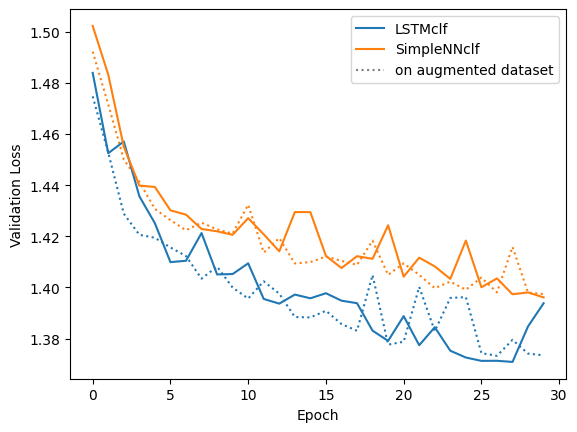

In [77]:
sns.lineplot(data=training_history_df[training_history_df.AugmentedDataset], x="Epoch", y="ValLoss", hue="Model", linestyle=":", legend=False)
sns.lineplot(data=training_history_df[~training_history_df.AugmentedDataset], x="Epoch", y="ValLoss", hue="Model")

handles, _ = plt.gca().get_legend_handles_labels()
line = Line2D([0], [0], label='on augmented dataset', color='gray', linestyle=':')
handles.append(line)
plt.legend(handles=handles)

plt.ylabel("Validation Loss")
plt.xlabel("Epoch")
plt.show()

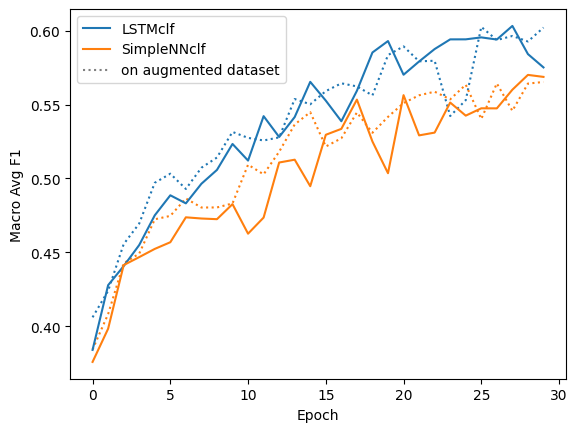

In [117]:
sns.lineplot(data=training_history_df[training_history_df.AugmentedDataset], x="Epoch", y="ValF1", hue="Model", linestyle=":", legend=False)
sns.lineplot(data=training_history_df[~training_history_df.AugmentedDataset], x="Epoch", y="ValF1", hue="Model")

handles, _ = plt.gca().get_legend_handles_labels()
line = Line2D([0], [0], label='on augmented dataset', color='gray', linestyle=':')
handles.append(line)
plt.legend(handles=handles)

plt.ylabel("Macro Avg F1")
plt.xlabel("Epoch")
plt.show()

In [114]:
max_f1_df = training_history_df.groupby(['Model', 'AugmentedDataset'])['ValF1'].max().reset_index().sort_values(by="ValF1", ascending=False)
max_f1_df

,Model,AugmentedDataset,ValF1
0,LSTMclf,False,0.603178
1,LSTMclf,True,0.602517
2,SimpleNNclf,False,0.570055
3,SimpleNNclf,True,0.565266


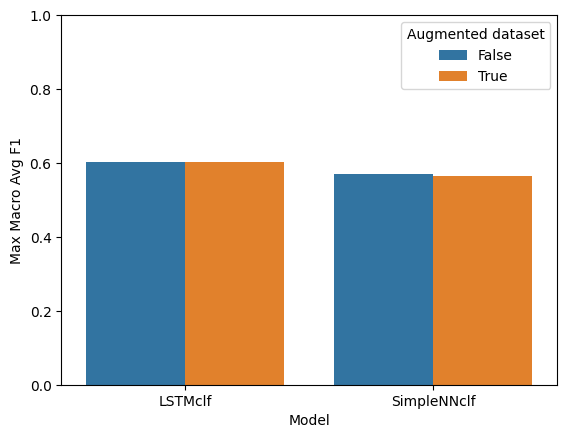

In [116]:
sns.barplot(data=max_f1_df, x="Model", y="ValF1", hue="AugmentedDataset")
plt.legend(loc='upper right', title="Augmented dataset")
plt.ylim(0, 1)
plt.ylabel("Max Macro Avg F1")
plt.show()

In [21]:
training_history_df.to_json("nlp_final_final_final_training_history_df.jsonl", orient="records", lines=True)